In [4]:
# This one is a special insurance with Rueckgewaehr (english: waiver of premium)
# This means the premium is returned in case of a premature death
# Pls consult lecture notes first
# Note it is based on the objects for annuities and capital
# For comments see there -ie capital and annuitz workbooks

import math
import numpy as np

filename = "EK95.txt"
EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(EKMF95[x,gender+1])

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def LinearIncrease(x,param=[]):
    x0 = param[0]
    s = param[1]
    P = param[2]
    if (x>= s): return(0)
    return(P * (x-x0+1.))

def LinearDecrease(x,param=[]):
    x0= param[0]
    L0= param[1]
    DeltaL = -param[2]
    if (x<x0): return(0.)
    return(max(0,L0 + (x-x0)*DeltaL))

def DeferredAnnuity(x,param=[]):
    x0= param[0]
    if (x<x0): return(0.)
    return(1.)
    
def TempAnnuity(x,param=[]):
    x0= param[0]
    if (x<x0): return(1.)
    return(0.)

import numpy as np
import matplotlib.pyplot as plt

class Capital:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymM = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.  #tp0
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = self.psymM(s,param=param)
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)
            
        return(CF)
    
class Annuity:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = 0
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px  * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
            
        return(CF)

We want to calculate the Praemienr\"uckge\"ahr, refund of premium. Problem if you pay a Premium for a deferred annuity, the you dont get anything in case of death. One could envidage a insuarance, where you get back the paid premium if you die prematurely.

*Benefits*

a) Annuity R ${}_m\ddot{a}_x$

b) if you die before $x+m$ you get the $\Pi$ back $\Pi \times (IA)_{x:m}$

c) if you die before having got app premiums back you are insured as difference of paid premium - paid annuities

*You pay:*

d) $\Pi \ddot{a}_{x:m}$

Current Age (40)  30
End Premium Payment age (65)  60
Gender (0 ==> m male, 1 ==> female)  1
Omega (110)  110


Equivalence: P x axm = naex + P IAan + P mDAx
Equivalence: P  = naex/(axm - IAan - mDAx)

------------
 Interation 1 
------------

PVL, PVP1, PVP2 11.400504153536724 22.740594242957975 -0.30055399819131057
DeltaL 1.9683375351260404
P0,L0 0.5080429459655486 28.03166246487396
Max RGW 14
------------
 Interation 2 
------------

PVP3 -0.4934082788802132
DeltaL 1.925058021147078
P0,L0 0.5194648623651007 28.074941978852923
Max RGW 14
DeltaP 0.011421916399552146
------------
 Interation 2 
------------

PVP3 -0.5124004540697475
DeltaL 1.9233921145403385
P0,L0 0.5199147861947977 28.076607885459662
Max RGW 14
DeltaP 0.0004499238296969965
------------
 Interation 2
------------
P0,L0 0.519932120152909 28.07667200921169
Max RGW 14
DeltaP 1.733395811132077e-05
------------
 Interation 3
------------
P0,L0 0.5199327873913435 28.07667447745064
Max RGW 14
DeltaP 6.672384345041138e-07
------------
 Interation 4
------------
P0,L0 0.5199328130745894 28.076674572457613
Max RGW 14
DeltaP 2.568324586338

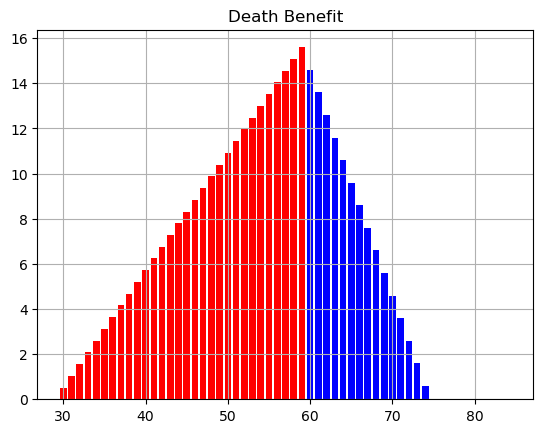

In [7]:
MyQx = QxNoReduction

x  = int(input("Current Age (40) ")) 
s = int(input("End Premium Payment age (65) "))
gender = int(input("Gender (0 ==> m male, 1 ==> female) "))
omega = int(input("Omega (110) "))



naex = Annuity(MyQx) # a)
IAxn = Capital(MyQx) # b)
mDAx = Capital(MyQx) # c)
axm = Annuity(MyQx)  # d)

naex.psymB = DeferredAnnuity
IAxn.psymB = LinearIncrease
IAxn.psymM = ZeroBenefit
mDAx.psymB = LinearDecrease
mDAx.psymM = ZeroBenefit
axm.psymB = TempAnnuity

print("Equivalence: P x axm = naex + P IAan + P mDAx" )
print("Equivalence: P  = naex/(axm - IAan - mDAx)\n" )

print("------------\n Interation %d \n------------\n"%(1))
PVL = naex.CalcPV(gender,x,omega, param =[s])
PVP1 = axm.CalcPV(gender,x,omega, param =[s])
PVP2 = -IAxn.CalcPV(gender,x,omega,param=[x,s,1.])
PNoRGW = PVL/PVP1

print("PVL, PVP1, PVP2",PVL, PVP1, PVP2)
P0 = PVL/(PVP1 + PVP2)
PRGW1 = P0
# P * DeltaL = 1
DeltaL = 1./P0
print("DeltaL",DeltaL)
L0 = (s-x) - DeltaL
print("P0,L0",P0,L0)
print("Max RGW",int(L0/DeltaL))
print("------------\n Interation %d \n------------\n"%(2))
PVP3 = -mDAx.CalcPV(gender,x,omega,param=[s,L0,DeltaL])
print("PVP3",PVP3)
Pold =P0
P0 = PVL/(PVP1 + PVP2 + PVP3)
DeltaL = 1./P0
print("DeltaL",DeltaL)
L0 = (s-x) - DeltaL
print("P0,L0",P0,L0)
print("Max RGW",int(L0/DeltaL))
print('DeltaP',P0-Pold)
print("------------\n Interation %d \n------------\n"%(2))
PVP3 = -mDAx.CalcPV(gender,x,omega,param=[s,L0,DeltaL])
print("PVP3",PVP3)
Pold =P0
P0 = PVL/(PVP1 + PVP2 + PVP3)
DeltaL = 1./P0
print("DeltaL",DeltaL)
L0 = (s-x) - DeltaL
print("P0,L0",P0,L0)
print("Max RGW",int(L0/DeltaL))
print('DeltaP',P0-Pold)
for i in range(15):
    print("------------\n Interation %d\n------------"%(i+2))
    PVP3 = -mDAx.CalcPV(gender,x,omega,param=[s,L0,DeltaL])
    #print("PVP3",PVP3)
    Pold =P0
    P0 = PVL/(PVP1 + PVP2 + PVP3)
    DeltaL = 1./P0
    #print("DeltaL",DeltaL)
    L0 = (s-x) - DeltaL
    print("P0,L0",P0,L0)
    print("Max RGW",int(L0/DeltaL))
    print('DeltaP',P0-Pold)
    
PRGW2 = P0

print("\n\nNo RGW", PNoRGW)
print("RGW 1 ", PRGW1)
print("RGW 2 ", PRGW2)

xx=[]
yy=[]
colorstack =[]

xx=range(x,85)
t=0
for i in xx:
    if(i<s):
        t+=PRGW2
        colorstack.append("r")
    else:
        t-=1.
        colorstack.append("b")
    yy.append(max(0,t))
    
plt.figure(1)
plt.bar(xx,yy,color=colorstack)
plt.title("Death Benefit")
plt.grid(True)


Age  30 Values:   0.0000  -0.0000   0.0000
Age  31 Values:   0.5114   0.5182   0.5303
Age  32 Values:   1.0331   1.0468   1.0713
Age  33 Values:   1.5653   1.5859   1.6230
Age  34 Values:   2.1083   2.1359   2.1858
Age  35 Values:   2.6622   2.6968   2.7599
Age  36 Values:   3.2274   3.2690   3.3455
Age  37 Values:   3.8040   3.8526   3.9428
Age  38 Values:   4.3923   4.4480   4.5521
Age  39 Values:   4.9927   5.0552   5.1735
Age  40 Values:   5.6054   5.6747   5.8075
Age  41 Values:   6.2307   6.3066   6.4542
Age  42 Values:   6.8688   6.9512   7.1139
Age  43 Values:   7.5203   7.6088   7.7869
Age  44 Values:   8.1853   8.2797   8.4734
Age  45 Values:   8.8643   8.9640   9.1738
Age  46 Values:   9.5577   9.6623   9.8884
Age  47 Values:  10.2659  10.3747  10.6175
Age  48 Values:  10.9894  11.1016  11.3614
Age  49 Values:  11.7287  11.8434  12.1205
Age  50 Values:  12.4842  12.6003  12.8952
Age  51 Values:  13.2567  13.3729  13.6858
Age  52 Values:  14.0468  14.1614  14.4928
Age  53 Val

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/var/folders/01/3sx_949s1jq1p4b651lcq1sm0000gn/T/ipykernel_93084/1879813077.py:28: SyntaxWarning: invalid escape sequence '\d'
  plt.legend(["${}_m|\ddot{a}_x$","RGW1","RGW2"])


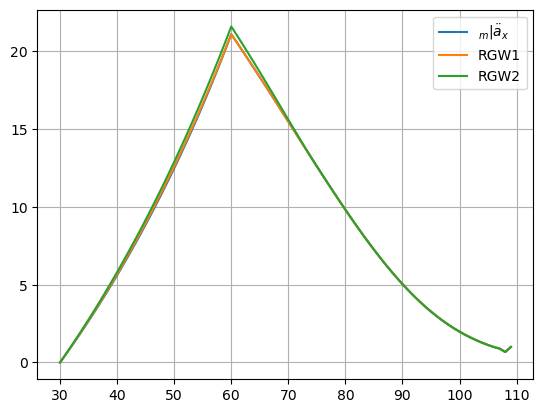

In [9]:
def DK(gender,x0,x,s,L,P1,P2,P3):
    a = []
    DeltaL = 1./P3
    L0 = (s-x0) - DeltaL
    a.append(L*naex.CalcPV(gender,x,omega, param =[s])-P1*axm.CalcPV(gender,x,omega, param =[s]))
    a.append(L*naex.CalcPV(gender,x,omega, param =[s])+P2* IAxn.CalcPV(gender,x,omega, param =[x0,s,1.])-P2*axm.CalcPV(gender,x,omega, param =[s]))
    a.append(L*naex.CalcPV(gender,x,omega, param =[s])+P3* IAxn.CalcPV(gender,x,omega, param =[x0,s,1.])+P3*mDAx.CalcPV(gender,x,omega,param=[s,L0,DeltaL])-P3*axm.CalcPV(gender,x,omega, param =[s]))
    #print("A:",L*naex.CalcPV(gender,x,omega, param =[s]),-P1*axm.CalcPV(gender,x,omega, param =[s]))
    #print("B:",L*naex.CalcPV(gender,x,omega, param =[s]),P2* IAxn.CalcPV(gender,x,omega, param =[x0,s,1.]),-P2*axm.CalcPV(gender,x,omega, param =[s]))
    #print("C:",L*naex.CalcPV(gender,x,omega, param =[s]),P3* IAxn.CalcPV(gender,x,omega, param =[x0,s,1.]),P3*mDAx.CalcPV(gender,x,omega,param=[s,L0,DeltaL]),-P3*axm.CalcPV(gender,x,omega, param =[s]))
    print("Age %3d Values: %8.4f %8.4f %8.4f"%(x,a[0],a[1],a[2]))
    return(a)

xx=[]
y1=[]
y2=[]
y3=[]

for i in range(x,110):
    xx.append(i)
    a,b,c= DK(gender,x,i,s,1,PNoRGW,PRGW1,PRGW2)
    y1.append(a)
    y2.append(b)
    y3.append(c)
    
plt.figure(1)
plt.plot(xx,y1,xx,y2,xx,y3)
plt.legend(["${}_m|\ddot{a}_x$","RGW1","RGW2"])
plt.grid(True)